# Predict ligand profiling using `kissim` (pooled Moret dataset)

In order to assess the predictive power of `kissim`, we here choose a ligand-centric evaluation. 
We will compare if `kissim` can predict on- and off-targets determined in ligand profiling studies.

- Kinase-kinase distance dataset (use KinMap kinase names): Select kinases from profiling dataset by query ligand
- Kinase-ligand profiling dataset (use KinMap kinase names and PKIDB ligand names): Select kinases from distances dataset by the ligand's on-target
- Merge both datasets and keep only kinases that have measurements in both datasets
- Rank kinases by distances
- Calculuate enrichment factors and enrichment plots
- Calculate ROC curves

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from src import data, evaluation
from src.paths import PATH_RESULTS

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
PATH_RANKS = PATH_RESULTS / "dfg_in/ranks"
PATH_RANKS.mkdir(exist_ok=True)
PATH_AUCS = PATH_RESULTS / "dfg_in/auc"
PATH_AUCS.mkdir(exist_ok=True)

In [4]:
plt.style.use("seaborn")

## Define parameters

In [5]:
# The only global that can be changed in this notebook
LIGAND_PROFILING_METHOD = "moret"

In [6]:
KINASE_DISTANCES_METHOD = "kissim"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 6
MIN_N_SHARED_ACTIVE_KINASES = 2

## Kinase-kinase distances dataset

__Criteria__: 

- Filters out kinases whose names cannot be mapped to KinMap kinase names.

In [7]:
# Full dataset (reported only, not further used)
kissim_df = data.distances.kissim(kinmap_kinases=False)
print(f"Kinase distance matrix shape: {kissim_df.shape}")

Kinase distance matrix shape: (257, 257)


In [8]:
# Reduced dataset
kissim_df = data.distances.kissim(kinmap_kinases=True)
print(f"Kinase distance matrix shape: {kissim_df.shape}")
kissim_df.iloc[:5, :5]

Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.kinmap
68         DCLK1                  DCAMKL1
120       JAK1-b                   JAK1_b
156       MSK1-b                   MSK1_b
175       PI4K2A  unknown (not in KinMap)
176        PI4KB  unknown (not in KinMap)
177       PIK3C3  unknown (not in KinMap)
206       RSK2-b                   RSK2_b
207       RSK3-b                   RSK3_b
232       TYK2-b                   TYK2_b
249        p110a  unknown (not in KinMap)
250        p110d  unknown (not in KinMap)
251        p110g  unknown (not in KinMap)


Kinase distance matrix shape: (251, 251)


,AAK1,ABL1,ABL2,ACK,ACTR2
AAK1,0.000000,0.107122,0.111726,0.108950,0.110255
ABL1,0.107122,0.000000,0.011441,0.066001,0.115258
ABL2,0.111726,0.011441,0.000000,0.066760,0.121243
ACK,0.108950,0.066001,0.066760,0.000000,0.121621
ACTR2,0.110255,0.115258,0.121243,0.121621,0.000000


## Kinase-ligand profiling dataset

__Criteria__:

- Load PKIDB ligands.
- Filters out ligands whose names cannot be mapped onto PKIDB ligand names.

In [9]:
# Full dataset (reported only, not further used)
profiling_df = data.profiling.load(LIGAND_PROFILING_METHOD)
print(f"Number of kinases (full dataset): {profiling_df.shape[0]}")
print(f"Number of ligands (full dataset): {profiling_df.shape[1]}")

Number of kinases (full dataset): 365
Number of ligands (full dataset): 138


In [10]:
# Reduced dataset
profiling_df = data.profiling.load(LIGAND_PROFILING_METHOD, pkidb_ligands=True, fda_approved=False, kinmap_kinases=True)
print(f"Number of kinases: {profiling_df.shape[0]}")
print(f"Number of ligands: {profiling_df.shape[1]}")
profiling_df.head()

Changed ligand names (unknown names may be discarded - see function docstring):
                            ligand.input            ligand.pkidb
0                                (-)-JQ1  unknown (not in PKIDB)
1    3,3',4',5-TETRACHLOROSALICYLANILIDE  unknown (not in PKIDB)
2                              A 1070722  unknown (not in PKIDB)
3                               A-674563  unknown (not in PKIDB)
4                            ABEMACICLIB             Abemaciclib
..                                   ...                     ...
133                          VISTUSERTIB             Vistusertib
134                              Y-27632  unknown (not in PKIDB)
135                          ZAFIRLUKAST  unknown (not in PKIDB)
136                         ZANUBRUTINIB  unknown (not in PKIDB)
137                       rac-CCT 250863  unknown (not in PKIDB)

[138 rows x 2 columns]
Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.k

Number of kinases: 333
Number of ligands: 71


,Abemaciclib,Acalabrutinib,Afatinib,Alectinib,Alpelisib,Alvocidib,Asciminib,Axitinib,Baricitinib,Binimetinib,...,Selumetinib,Sorafenib,Sunitinib,Tivozanib,Tofacitinib,Tozasertib,Trametinib,Vandetanib,Vemurafenib,Vistusertib
AAK1,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,...,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABL1,NaN,NaN,500.0,NaN,NaN,NaN,0.5,3.6,NaN,NaN,...,NaN,215.0,202.0,195.0,NaN,NaN,NaN,20.0,NaN,NaN
ABL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.0,NaN,NaN,...,NaN,NaN,NaN,302.0,NaN,NaN,NaN,69.0,NaN,NaN
ALK2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN
ALK4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


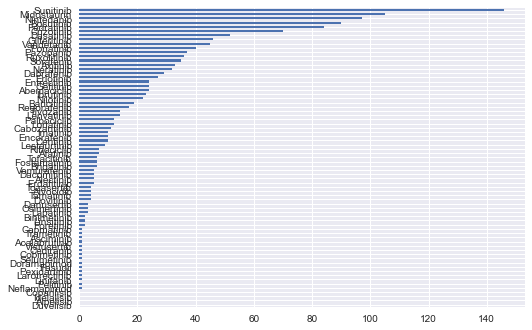

In [11]:
profiling_df.count().sort_values().plot(kind="barh");

## Ligands' on-targets dataset

__Criteria__: 

- Filters out ligands that are not available in the PKIDB or have no targets in the PKIDB.
- Filters out targets whose names cannot be mapped onto KinMap names

In [12]:
pd.set_option("max_colwidth", 100)
ligand_names = profiling_df.columns
ligand_targets = data.targets.pkidb(ligand_names, fda_approved=False)
ligand_targets

Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.kinmap
4          ERBB2                    ErbB2
5          ERBB4                    ErbB4
7         PIK3CA  unknown (not in KinMap)
8            nan  unknown (not in KinMap)
9            nan  unknown (not in KinMap)
..           ...                      ...
216        AURKC                     AurC
220        VEGFA  unknown (not in KinMap)
222         PTK6                      BRK
223          TEK                     TIE2
226         MTOR                     FRAP

[64 rows x 2 columns]


,ligand.input,targets.pkidb,targets.kinmap
0,Vistusertib,[MTOR],[FRAP]
1,Gefitinib,[EGFR],[EGFR]
2,Fostamatinib,[SYK],[SYK]
3,Lestaurtinib,[FLT3],[FLT3]
4,Erlotinib,[EGFR],[EGFR]
...,...,...,...
58,Nintedanib,"[FLT1, KDR, FLT4, FGFR1, FGFR2, FGFR3, FLT3, LCK, LYN, SRC]","[FLT1, KDR, FLT4, FGFR1, FGFR2, FGFR3, FLT3, LCK, LYN, SRC]"
59,Bosutinib,"[BCR, ABL1, LYN, HCK, SRC, CDK2, MAP2K1, MAP2K2, MAP3K2, CAMK2G]","[BCR, ABL1, LYN, HCK, SRC, CDK2, MAP2K1, MAP2K2, MAP3K2, CaMK2g]"
60,Sorafenib,"[BRAF, RAF1, FLT4, KDR, FLT3, PDGFRB, KIT, FGFR1, RET, FLT1]","[BRAF, RAF1, FLT4, KDR, FLT3, PDGFRb, KIT, FGFR1, RET, FLT1]"
61,Ponatinib,"[ABL1, BCR, KIT, RET, TEK, FLT3, FGFR1, FGFR2, FGFR3, FGFR4, LCK, SRC, LYN, KDR, PDGFRA]","[ABL1, BCR, KIT, RET, TIE2, FLT3, FGFR1, FGFR2, FGFR3, FGFR4, LCK, SRC, LYN, KDR, PDGFRa]"


### Ligand-kinase datasets

We merge now profiling and kinase similarity information into one dataset per ligand-kinase pair (_ligand-kinase dataset_). 

We only keep ligand-kinase pairs that
- have a minimum of `MIN_N_SHARED_KINASES` shared kinases
- have a minimum of `MIN_N_SHARED_ACTIVE_KINASES` shared active kinases, while activity is defined <= `KINASE_ACTIVITY_CUTOFF`

Select ligand-kinase pairs with enough coverage.

In [13]:
ligand_kinase_pairs = (
    ligand_targets[["ligand.input", "targets.kinmap"]]
    .explode("targets.kinmap")
    .to_numpy()
    .tolist()
)

## Evaluation metrics

In [14]:
evaluator = evaluation.LigandVsKinaseEvaluator(
    ligand_kinase_pairs,
    LIGAND_PROFILING_METHOD,
    KINASE_DISTANCES_METHOD,
    KINASE_ACTIVITY_CUTOFF,
    KINASE_ACTIVITY_MAX,
    MIN_N_SHARED_KINASES,
    MIN_N_SHARED_ACTIVE_KINASES,
)

Changed ligand names (unknown names may be discarded - see function docstring):
                            ligand.input            ligand.pkidb
0                                (-)-JQ1  unknown (not in PKIDB)
1    3,3',4',5-TETRACHLOROSALICYLANILIDE  unknown (not in PKIDB)
2                              A 1070722  unknown (not in PKIDB)
3                               A-674563  unknown (not in PKIDB)
4                            ABEMACICLIB             Abemaciclib
..                                   ...                     ...
133                          VISTUSERTIB             Vistusertib
134                              Y-27632  unknown (not in PKIDB)
135                          ZAFIRLUKAST  unknown (not in PKIDB)
136                         ZANUBRUTINIB  unknown (not in PKIDB)
137                       rac-CCT 250863  unknown (not in PKIDB)

[138 rows x 2 columns]
Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.k

In [15]:
print(f"Number of pairs: {len(evaluator.ligand_kinase_pairs)}")
print(f"Number of ligands: {len(set([i[0] for i in evaluator.ligand_kinase_pairs]))}")

Number of pairs: 214
Number of ligands: 63


### Ligand types

In [16]:
pkidb = data.ligands.pkidb()
ligands = pkidb.set_index("ID")["Type"][list(evaluator.data_dict.keys())].reset_index()
ligands

,ID,Type
0,Vistusertib,nan
1,Gefitinib,1.5
2,Erlotinib,1.5
3,Erdafitinib,1
4,Linsitinib,nan
5,Neflamapimod,nan
6,Dacomitinib,1
7,Vemurafenib,1.5
8,Osimertinib,1
9,Acalabrutinib,nan


### Enrichment

#### Enrichment factor 

An enrichment factor is calculated as follows:

$EF_{x\%} = \frac{\frac{n_s}{n}}{\frac{N_s}{N}}$

with

- $N$   : Number of kinases in total
- $N_s$ : Number of kinases in top x% of ranked kinases
- $n$   : Number of active kinases in total
- $n_s$ : Number of active kinases in top x% of ranked kinases

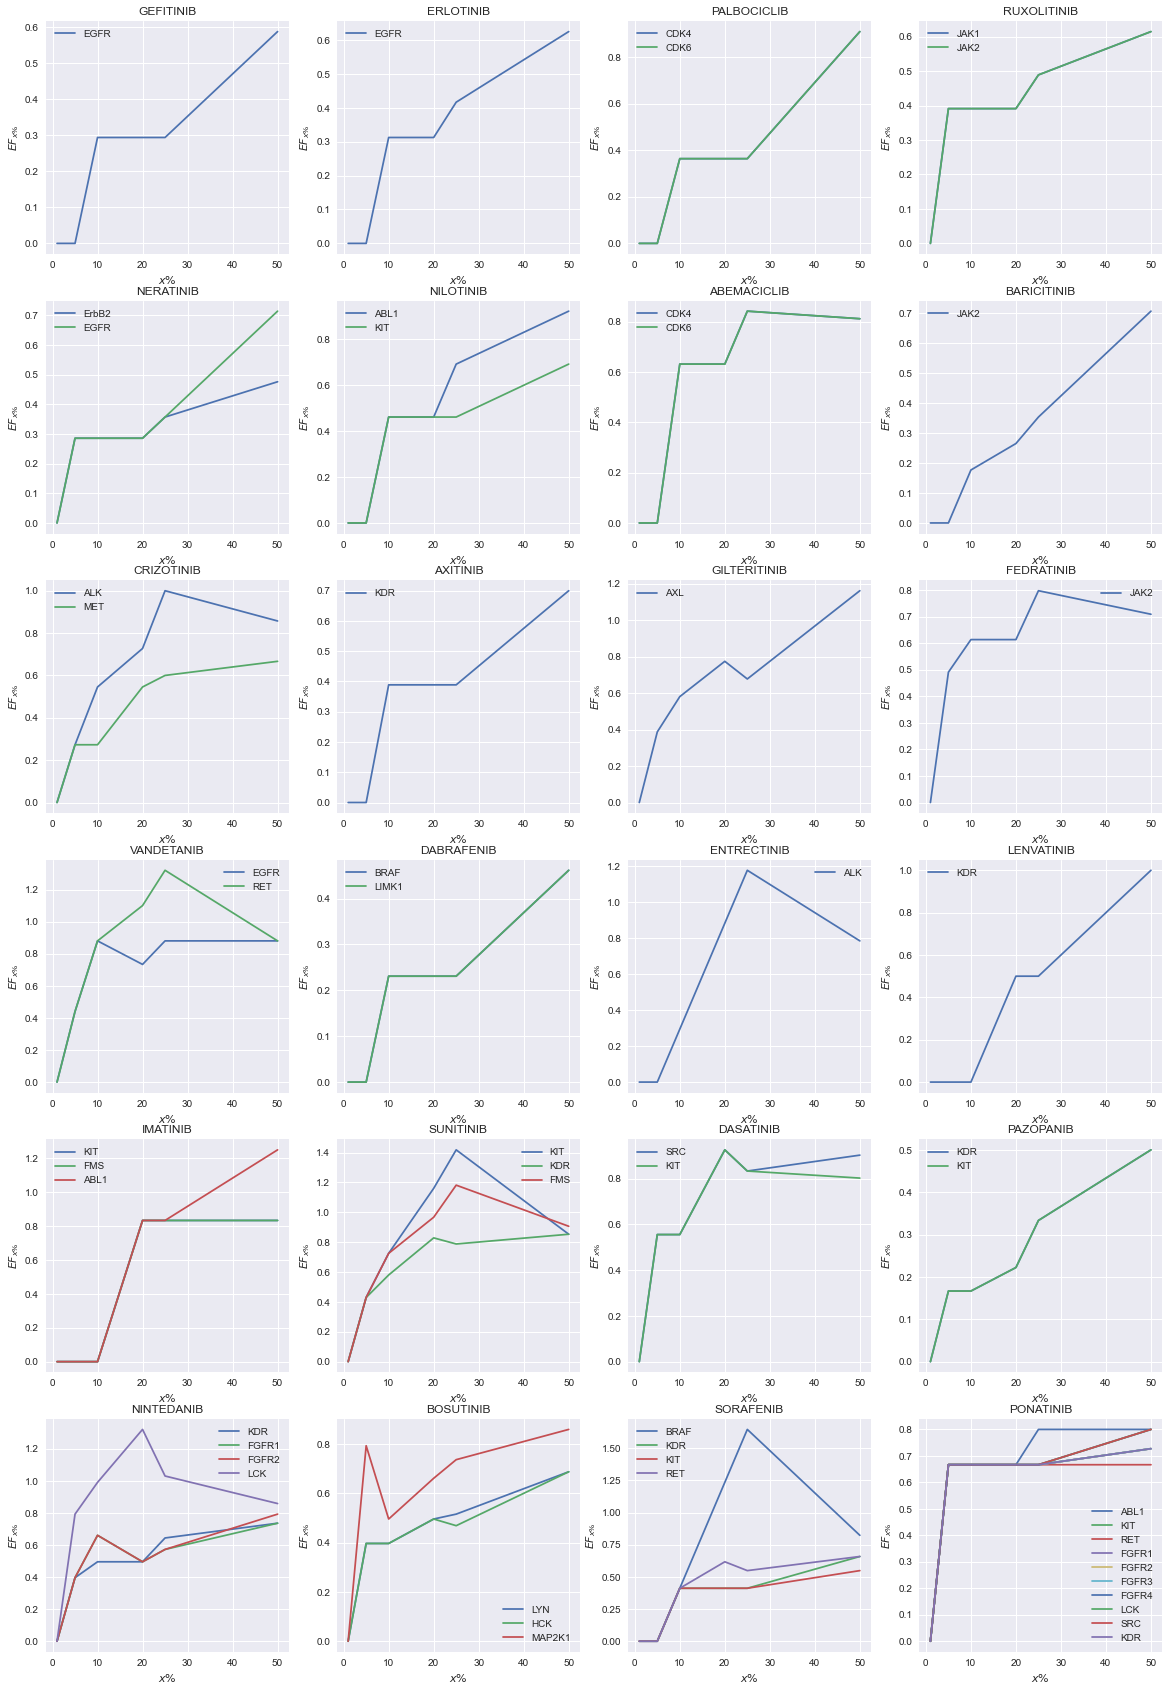

In [17]:
evaluator.plot_enrichment_factors()

#### Enrichment plots

For an enrichment plot, the x and y values are calculated as follows:

$x = \frac{N_s}{N}$, $y = \frac{n_s}{n}$

with

- $N$   : Number of kinases in total
- $N_s$ : Number of kinases in top x% of ranked kinases
- $n$   : Number of active kinases in total
- $n_s$ : Number of active kinases in top x% of ranked kinases

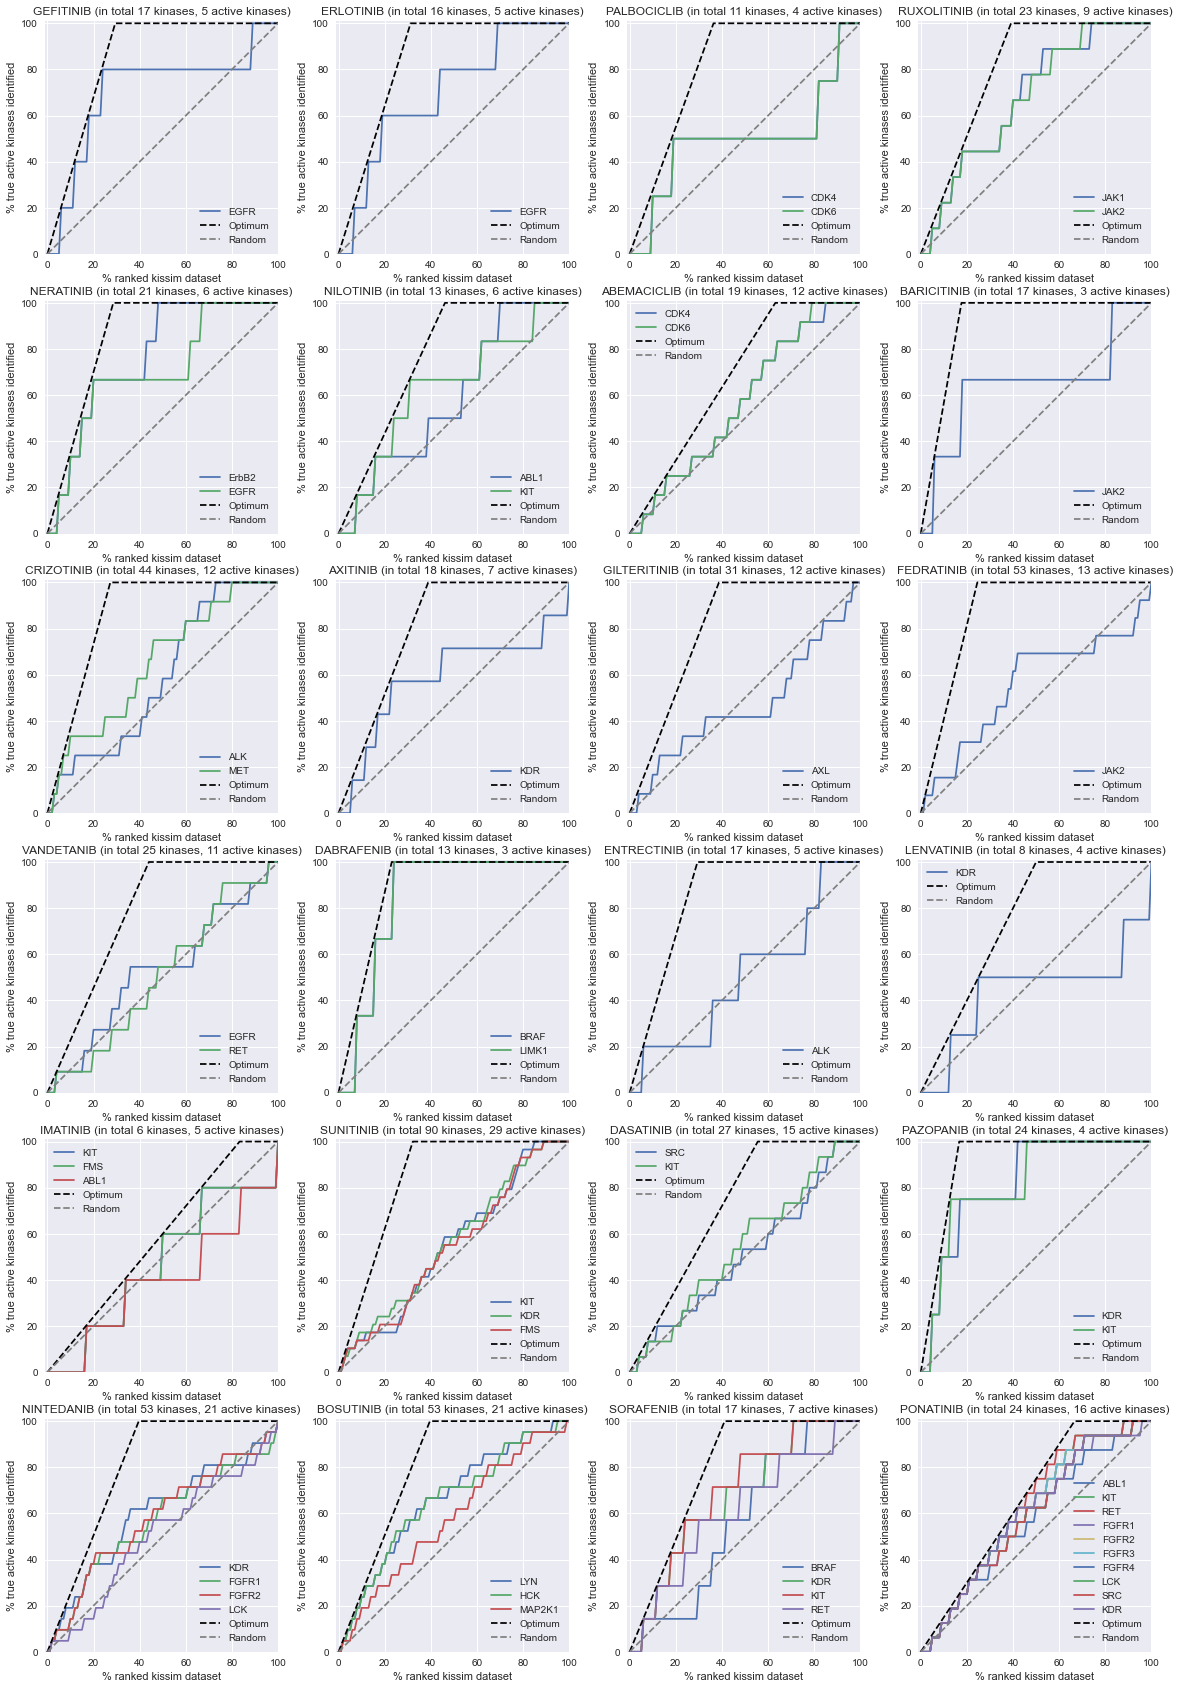

In [18]:
evaluator.plot_enrichment()

### ROC curves

- $TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$
- $FPR = \frac{FP}{N} = \frac{FP}{FP + TN}$

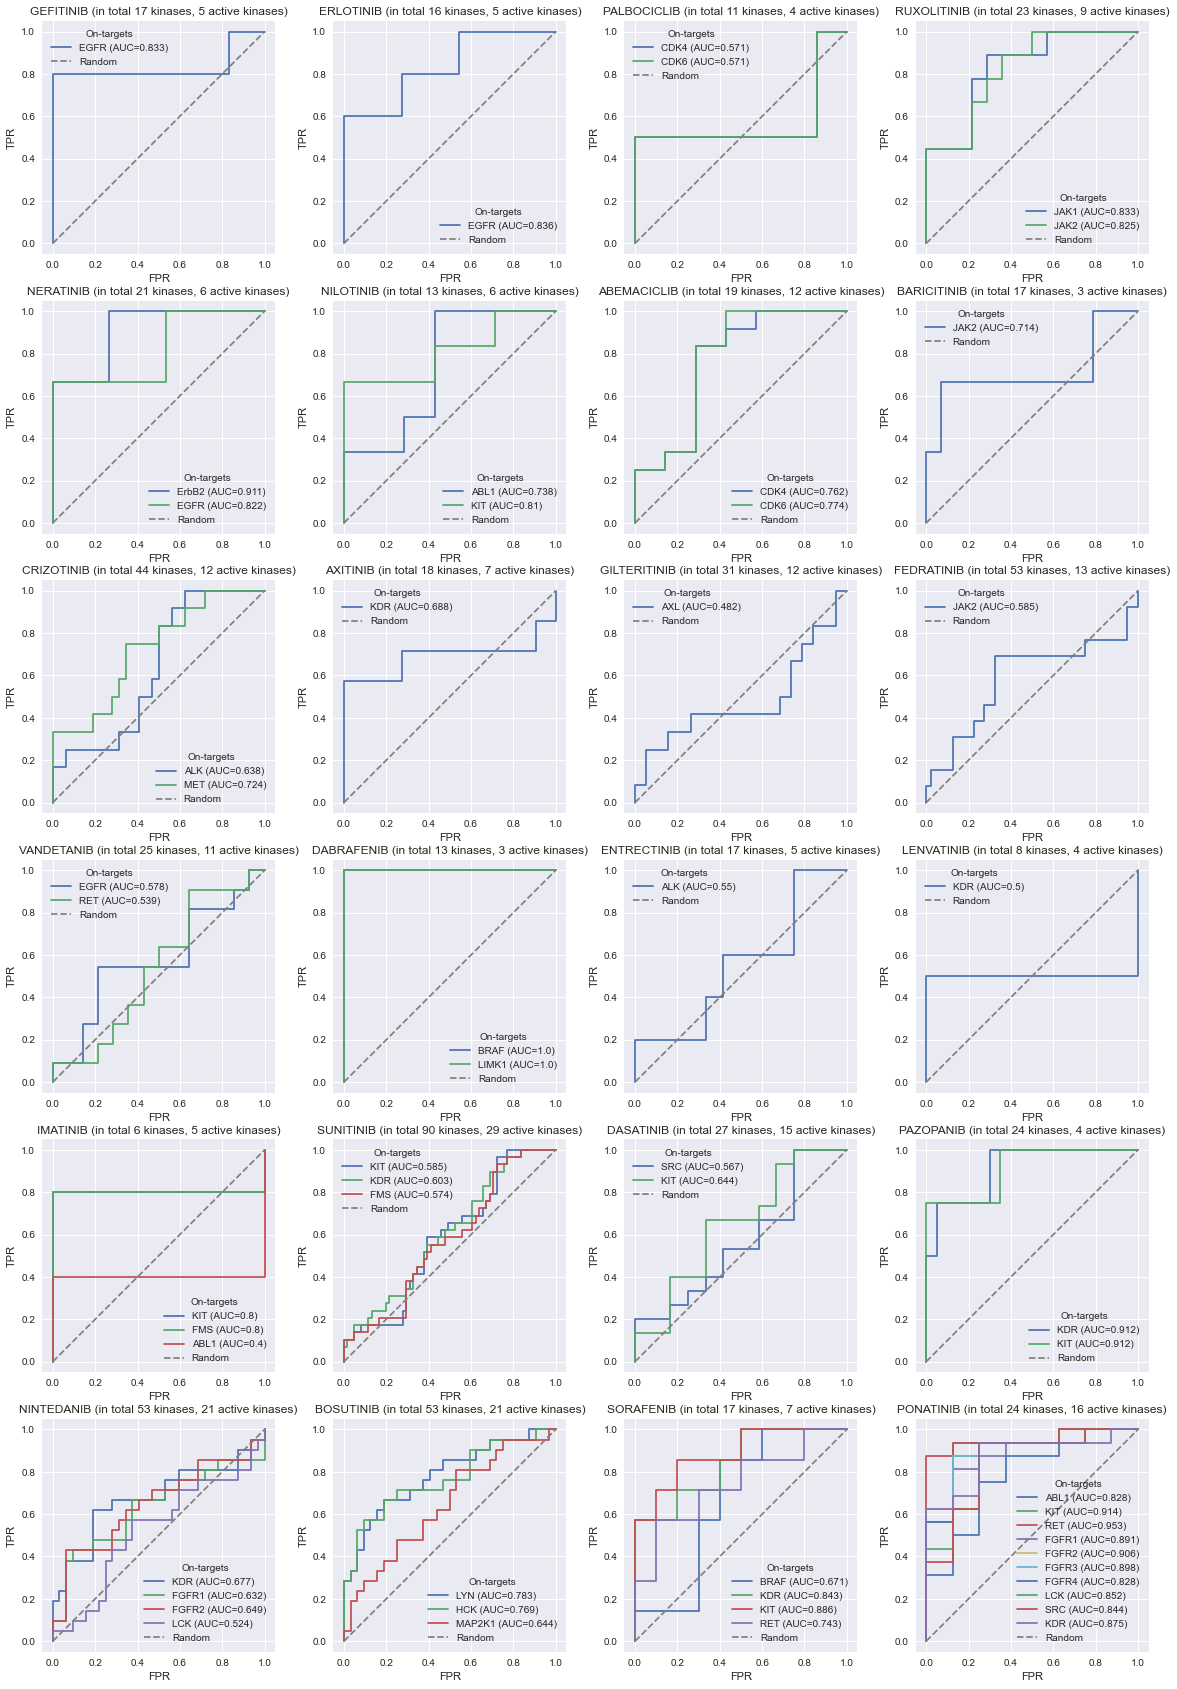

In [19]:
auc_dict = evaluator.plot_roc_curves(HERE / f"../figures/profiling_roc_dfg_in_{LIGAND_PROFILING_METHOD}.pdf")
auc_list = list(auc_dict.values())

In [20]:
# Save AUC values to file
pd.DataFrame(
    [entry[0].split("-") + [entry[1]] for entry in auc_dict.items()],
    columns=["ligand", "kinase", "auc"],
).to_csv(PATH_AUCS / f"auc_{KINASE_DISTANCES_METHOD}_vs_{LIGAND_PROFILING_METHOD}.csv")

In [21]:
print(f"Number of pairs: {len(auc_list)}")

Number of pairs: 55


In [22]:
np.mean(auc_list)

0.7399005723069798

In [23]:
np.std(auc_list)

0.14475307809239624

In [24]:
print(np.min(auc_list), np.max(auc_list))

0.4 1.0


#### Selected ligand ROC curves

In [25]:
selected_ligands = ["Erlotinib", "Imatinib", "Bosutinib", "Doramapimod"]

In [26]:
# Select pairs based on selected ligands (in given order!!)
# Looks a bit complicated but necessary to keep ligand order!
ligand_kinase_pairs_df = pd.DataFrame(ligand_kinase_pairs, columns=["ligand", "kinase"])
ligand_kinase_pairs_selected = []
for selected_ligand in selected_ligands:
    ligand_kinase_pairs_selected.append(
        ligand_kinase_pairs_df.groupby("ligand").get_group(selected_ligand)
    )
ligand_kinase_pairs_selected = pd.concat(ligand_kinase_pairs_selected).values.tolist()

In [27]:
evaluator_selected = evaluation.LigandVsKinaseEvaluator(
    ligand_kinase_pairs_selected,
    LIGAND_PROFILING_METHOD,
    KINASE_DISTANCES_METHOD,
    KINASE_ACTIVITY_CUTOFF,
    KINASE_ACTIVITY_MAX,
    MIN_N_SHARED_KINASES,
    MIN_N_SHARED_ACTIVE_KINASES,
)

                            ligand.input            ligand.pkidb
0                                (-)-JQ1  unknown (not in PKIDB)
1    3,3',4',5-TETRACHLOROSALICYLANILIDE  unknown (not in PKIDB)
2                              A 1070722  unknown (not in PKIDB)
3                               A-674563  unknown (not in PKIDB)
4                            ABEMACICLIB             Abemaciclib
..                                   ...                     ...
133                          VISTUSERTIB             Vistusertib
134                              Y-27632  unknown (not in PKIDB)
135                          ZAFIRLUKAST  unknown (not in PKIDB)
136                         ZANUBRUTINIB  unknown (not in PKIDB)
137                       rac-CCT 250863  unknown (not in PKIDB)

[138 rows x 2 columns]
    kinase.input            kinase.kinmap
3          ACVR1                     ALK2
4         ACVR1B                     ALK4
5         ACVR2B                   ACTR2B
6         ACVRL1            

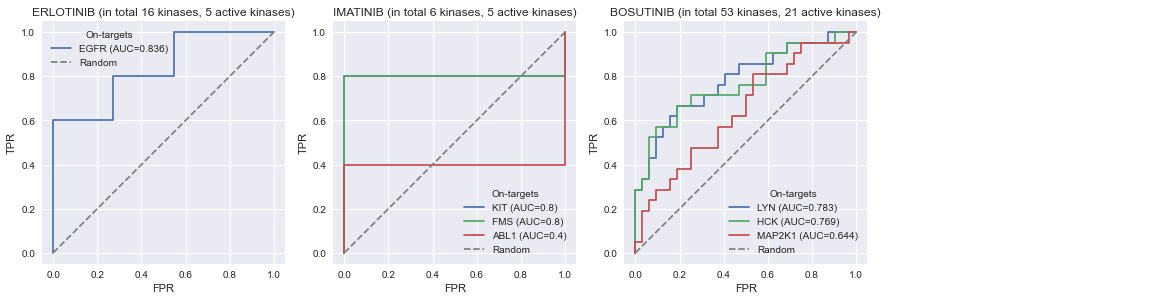

In [28]:
evaluator_selected.plot_roc_curves(HERE / f"../figures/profiling_roc_dfg_in_selected_{LIGAND_PROFILING_METHOD}.png");

### In detail: Look at ranks!

In [29]:
from opencadd.databases.klifs import setup_remote

In [30]:
def show_ranking(evaluator, kinase, ligand):
    session = setup_remote()
    ranking = evaluator.data_dict[ligand][kinase].data
    kinase_groups = session.kinases.by_kinase_name(ranking.index.to_list(), species="Human")[
        ["kinase.klifs_name", "kinase.group"]
    ].set_index("kinase.klifs_name")
    ranking = pd.merge(ranking, kinase_groups, left_index=True, right_index=True)
    return ranking

In [31]:
pairs = [
    ["EGFR", "Erlotinib"],
    ["ABL1", "Imatinib"],
    ["ABL1", "Bosutinib"],
    ["p38a", "Doramapimod"],
]

In [32]:
for kinase, ligand in pairs:
    display(Markdown(f"#### {ligand}"))
    try:
        ranks = show_ranking(evaluator_selected, kinase, ligand)
        display(HTML(ranks.to_html()))
        display(HTML(ranks[ranks["karaman-davis.active"]].to_html()))
        ranks[ranks["karaman-davis.active"]].to_csv(
            PATH_RANKS / f"ranks_{KINASE_DISTANCES_METHOD}_{ligand}_{kinase}.csv"
        )
    except KeyError:
        print(f"Data unavailable for {kinase} and {ligand}")

#### Erlotinib

,moret.measure,moret.active,moret.rank1,moret.rank2,kissim.measure,kissim.rank1,kissim.rank2,kinase.group
EGFR,0.52,True,1.0,1.0,0.000000,1.0,1.0,TK
ErbB4,2.72,True,2.0,2.0,0.024878,2.0,2.0,TK
ErbB2,95.00,True,6.0,5.0,0.039648,3.0,3.0,TK
ABL1,150.00,False,7.0,6.0,0.063537,8.0,4.0,TK
ABL2,200.00,False,9.0,7.0,0.067081,17.0,5.0,TK
KDR,678.00,False,18.0,13.0,0.068191,19.0,6.0,TK
LOK,19.00,True,3.0,3.0,0.071240,27.0,7.0,STE
JAK3,815.00,False,23.0,15.0,0.073378,32.0,8.0,TK
LYN,437.00,False,12.0,9.0,0.073851,36.0,9.0,TK
LCK,320.00,False,10.0,8.0,0.075684,41.0,10.0,TK


Data unavailable for EGFR and Erlotinib


#### Imatinib

,moret.measure,moret.active,moret.rank1,moret.rank2,kissim.measure,kissim.rank1,kissim.rank2,kinase.group
ABL1,21.0,True,4.0,3.0,0.000000,1.0,1.0,TK
ABL2,10.0,True,1.0,1.0,0.011441,2.0,2.0,TK
LYN,717.0,False,10.0,6.0,0.060128,13.0,3.0,TK
LCK,56.5,True,8.0,5.0,0.062334,18.0,4.0,TK
KIT,31.3,True,6.0,4.0,0.069289,40.0,5.0,TK
FMS,15.0,True,2.5,2.0,0.072250,45.0,6.0,TK


Data unavailable for ABL1 and Imatinib


#### Bosutinib

Data unavailable for ABL1 and Bosutinib


#### Doramapimod

Data unavailable for p38a and Doramapimod
